In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("../sales_train.csv.gz")
test_df  = pd.read_csv("../test.csv.gz")

categories = pd.read_csv('../item_categories.csv')
items = pd.read_csv('../items.csv')

In [2]:
#%store -r __decomp_shop_20191006
%store -r __trends2_20191006

In [3]:
%%time
#_decomp_shop_20191006

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [4]:
%%time
__trends2_20191006

CPU times: user 1min 35s, sys: 49.1 s, total: 2min 24s
Wall time: 2min 37s


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


CPU times: user 497 ms, sys: 59 ms, total: 556 ms
Wall time: 558 ms
[0, 1, 5, 8, 9, 10, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 34, 36, 39, 40, 43, 48, 49, 51, 54, 55, 57, 58]
CPU times: user 33min 16s, sys: 44 s, total: 34min
Wall time: 21min 45s
RMSE good: 0.915369
Average good: 0.28599790008607
RMSE bad: 1.076487
Average bad: 0.21817210595657685
name                                              score
total_monthly_item_sales_lag_1                0.388521
total_monthly_shop_category_sales_lag_1       0.0854018
target_lag_1                                  0.0680341
total_monthly_shop_subcategory_sales_lag_1    0.0679278
total_monthly_category_sales_lag_1            0.0420121
shop_trend                                    0.038477
shop_forecast                                 0.0376143
target_lag_2                                  0.0364742
total_monthly_shop_supercategory_sales_lag_1  0.0343748
total_monthly_subcategory_sales_lag_1         0.0321812
target_lag_3                       

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:126: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



CPU times: user 1h 11min 54s, sys: 2min 57s, total: 1h 14min 52s
Wall time: 1h 1min 24s
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1107c9320> (for post_execute):


ValueError: view limit minimum -36793.6 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36793.6 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

CPU times: user 828 ms, sys: 237 ms, total: 1.06 s
Wall time: 1.13 s


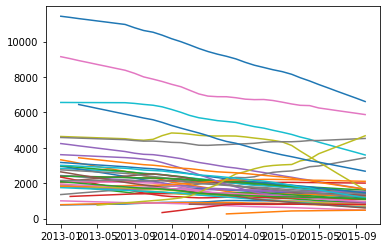

In [5]:
%%time
from statsmodels.tsa.seasonal import seasonal_decompose

shop_monthly_sales = monthly.groupby(["shop_id","date_block_num"]).target.sum().reset_index("shop_id")

decomposition_shop = pd.DataFrame()

closed_shops = []

for shop in shop_monthly_sales.shop_id.unique():

    sales = shop_monthly_sales[shop_monthly_sales.shop_id==shop]
    sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])

#    # some shop close and open/reopen, don't forecast those yet?
#    if any(sales_ts.target.isnull()) :
#        closed_shops.append(shop)
#        continue
        
    # if last X positions are not known consider the shop is closed
    if sum( sales_ts[-3:].target.isnull() ) == 3:
        closed_shops.append(shop)
        continue

    # last months sales are present, but not enough lags for seasonal inference => closed
    if sum(~ np.isnan(sales_ts.target)) < 12:
        closed_shops.append(shop)
        continue

    # do the best with the rest
    if any(np.isnan(sales_ts.target)):
        start = min( np.where(~ np.isnan(sales_ts.target))[0] )
        end   = max( np.where(~ np.isnan(sales_ts.target))[0] )
        sales_ts = sales_ts[start:]

    # at this point first and last observations are not zeros, let's bridge the gaps
    sales_ts.target = sales_ts.target.interpolate()

    ts = pd.Series(sales_ts.target.values, index=sales_ts["begin_date"])

    decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.plot(trend, label='Trend')
    decomposition_shop = pd.concat([decomposition_shop,
                             pd.DataFrame({
                                 'date_block_num':  sales_ts.date_block_num,
                                 'shop_id':         [shop]*len(ts),
                                 'shop_trend':      trend.values,
                                 'shop_seasonal':   seasonal.values,
                                 'shop_forecast':   trend.values + seasonal.values
                             })])

In [6]:
extrapolate = lambda x: np.poly1d( np.polyfit([1,2,3], [x.iloc[-3],x.iloc[-2],x.iloc[-1]], 1) )(4)
#extrapolate.__name__ = "shop_trend"

trend_34 = decomposition_shop.groupby(["shop_id"]).agg({"shop_trend": [extrapolate]})
trend_34.columns = ["shop_trend"]
trend_34.reset_index()

seasonal_22 = decomposition_shop[decomposition_shop.date_block_num==(34-12)][['shop_id','shop_seasonal']]

forecast_34 = pd.merge(trend_34, seasonal_22, how='inner', on=['shop_id'])
forecast_34['date_block_num'] = 34
forecast_34['shop_forecast'] = forecast_34['shop_trend'] + forecast_34['shop_seasonal']

decomposition_shop = pd.concat([decomposition_shop, forecast_34], sort=True, ignore_index=True)

34       841.020255
35       753.381366
36       900.061921
37       669.798032
38       731.214699
39       764.228588
40       686.075810
41       849.756366
42       960.089699
43       802.423032
44      1018.027199
45      1212.506366
46       950.686921
47       853.589699
48       986.520255
49       742.506366
50       796.798032
51       828.061921
52       744.659144
53       891.589699
54       971.923032
55       793.714699
56      1005.402199
57      1186.923032
58       905.936921
59       787.673032
60       904.061921
61       645.339699
62       674.631366
63       677.353588
64       568.909144
65       702.298032
66       784.631366
67       600.506366
1396     792.985532
Name: shop_forecast, dtype: float64

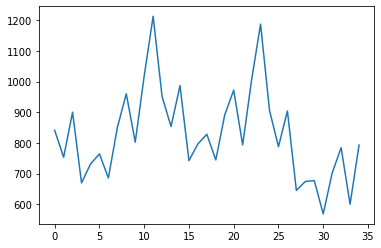

In [7]:
plt.plot(decomposition_shop[decomposition_shop.shop_id==3].shop_forecast.ravel(), label='QWE')
decomposition_shop[decomposition_shop.shop_id==3].shop_forecast

In [8]:
print(closed_shops)
all_data[all_data.shop_id==8].date_block_num.unique()

[0, 1, 8, 9, 11, 13, 17, 20, 23, 29, 30, 32, 33, 36, 40, 43, 54]


array([0, 1, 2, 3])

(array([5., 3., 2., 1., 0., 0., 2., 0., 2., 2.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

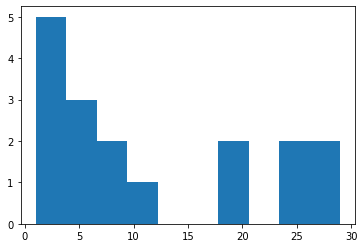

In [9]:
open_months = []
for shop in closed_shops:
    sales = shop_monthly_sales[shop_monthly_sales.shop_id == shop]
    open_months.append(len(sales))
open_months
plt.hist(open_months)
#closed_for_good

In [10]:
extrapolate_closed_shops = pd.DataFrame()

for shop in closed_shops:

    sales = shop_monthly_sales[shop_monthly_sales.shop_id==shop]
    sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])

    # if last X positions are not known consider the shop is closed
    if sum( sales_ts[-3:].target.isnull() ) == 3:
        extrapolate_closed_shops = pd.concat([extrapolate_closed_shops,
                             pd.DataFrame({
                                 'date_block_num':  [33,34],
                                 'shop_id':         [shop, shop],
                                 'shop_forecast':   [0]*2
                             })])
        continue

    # last months sales are present, but not enough lags for seasonal inference => average
    if sum(~ np.isnan(sales_ts.target)) < 12:
        extrapolate_closed_shops = pd.concat([extrapolate_closed_shops,
                             pd.DataFrame({
                                 'date_block_num':  [33,34],
                                 'shop_id':         [shop, shop],
                                 'shop_forecast':   [np.nanmean(sales_ts[-3:].target)]*2
                             })])
        continue

    print("Shop #{0} should be here".format(shop))

In [11]:
all_good_data = pd.merge(all_data, decomposition_shop, how='right', on=['date_block_num','shop_id'])
all_bad_data = pd.merge(all_data, extrapolate_closed_shops, how='right', on=['date_block_num','shop_id'])
#all_bad_data  = all_data[all_data.shop_id.isin(closed_shops)]

In [12]:
train_good = all_good_data[(all_good_data.date_block_num>12)&(all_good_data.date_block_num<34)].fillna(0)
train_bad  = all_bad_data [all_bad_data.date_block_num ==33].fillna(0)

predictors_bad = predictors + ['shop_forecast']
predictors_good = predictors + ['shop_trend', 'shop_seasonal', 'shop_forecast'] 

X_train_good = train_good[train_good.date_block_num <  33][predictors_good]
X_valid_good = train_good[train_good.date_block_num == 33][predictors_good]
y_train_good = train_good[train_good.date_block_num <  33].target
y_valid_good = train_good[train_good.date_block_num == 33].target

In [13]:
%%time
# compare with previous iteration
from sklearn.ensemble import RandomForestRegressor
new_model_good = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=6) #len(predictors)/2
new_model_good.fit(X_train_good, y_train_good)

from sklearn.metrics import mean_squared_error

ypred_good = new_model_good.predict(X_valid_good)
rmse = np.sqrt(mean_squared_error(y_valid_good, ypred_good))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred_good)))

RMSE good: 0.877994
Average good: 0.26882049136368974
CPU times: user 32min 3s, sys: 28.3 s, total: 32min 31s
Wall time: 8min 51s


In [14]:
# so combined model with imputed shops perform not as good as good_model from before
best_shops = []
extrapolate_best_shops = pd.DataFrame()

for shop in shop_monthly_sales.shop_id.unique():

    sales = shop_monthly_sales[shop_monthly_sales.shop_id==shop]
    sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])

    # some shop close and open/reopen, don't forecast those yet?
    if any(sales_ts.target.isnull()) :
        continue

    best_shops.append(shop)

    ts = pd.Series(sales_ts.target.values, index=sales_ts["begin_date"])

    decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    extrapolate_best_shops = pd.concat([extrapolate_best_shops,
                             pd.DataFrame({
                                 'date_block_num':  sales_ts.date_block_num,
                                 'shop_id':         [shop]*len(ts),
                                 'shop_trend':      trend.values,
                                 'shop_seasonal':   seasonal.values,
                                 'shop_forecast':   trend.values + seasonal.values
                             })])

trend_34 = extrapolate_best_shops.groupby(["shop_id"]).agg({"shop_trend": [extrapolate]})
trend_34.columns = ["shop_trend"]
trend_34.reset_index()

seasonal_22 = extrapolate_best_shops[extrapolate_best_shops.date_block_num==(34-12)][['shop_id','shop_seasonal']]

forecast_34 = pd.merge(trend_34, seasonal_22, how='inner', on=['shop_id'])
forecast_34['date_block_num'] = 34
forecast_34['shop_forecast'] = forecast_34['shop_trend'] + forecast_34['shop_seasonal']

extrapolate_best_shops = pd.concat([extrapolate_best_shops, forecast_34], sort=True, ignore_index=True)    

all_best_data = pd.merge(all_data, extrapolate_best_shops, how='right', on=['date_block_num','shop_id'])

In [15]:
%%time
from sklearn.ensemble import RandomForestRegressor
full_model_good = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=6) #len(predictors)/2
full_model_good.fit(train_good[predictors_good], train_good.target)

full_model_bad = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=6) #len(predictors)/2
full_model_bad.fit(train_bad[predictors_bad], train_bad.target)

CPU times: user 33min 16s, sys: 30.1 s, total: 33min 47s
Wall time: 9min 49s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [16]:
month_34_good = all_good_data[all_good_data.date_block_num == 34].fillna(0)
month_34_good = month_34_good[~ month_34_good.shop_id.isin(best_shops)]
month_34_good['item_cnt_month'] = full_model_good.predict(month_34_good[predictors_good])

# best for good_model from before
month_34_best = all_best_data[all_best_data.date_block_num == 34].fillna(0)
month_34_best['item_cnt_month'] = model_good.predict(month_34_best[predictors_good])

month_34_bad = all_bad_data[all_bad_data.date_block_num == 34].fillna(0)
month_34_bad['item_cnt_month'] = full_model_bad.predict(month_34_bad[predictors_bad])

month_34 = pd.concat([month_34_best, month_34_good, month_34_bad], ignore_index=True)

test = pd.merge(test_df, month_34, on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"].round().astype("int64")

test[test.item_cnt_month>20] = 20
test.to_csv("shop_trends.csv")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


Now let us do the same for items

In [17]:
test.shape

(214200, 1)

In [18]:
# public score: 1.03958
# now you need to see why imputed "bad" is screwing the performance

In [19]:
model_bad_old = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=4)
model_bad_old.fit(X_train_bad, y_train_bad)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [20]:
month_34_bad_old = all_data[(~all_data.shop_id.isin(best_shops)) & (all_data.date_block_num == 34)].fillna(0)
month_34_bad_old['item_cnt_month'] = model_bad_old.predict(month_34_bad_old[predictors])

month_34_old = pd.concat([month_34_best, month_34_bad_old], ignore_index=True)

test = pd.merge(test_df, month_34_old, on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"].round().astype("int64")

test[test.item_cnt_month>20] = 20
test.to_csv("_shop_trends.csv")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [21]:
# now public score is back to 1.03414

In [22]:
month_34_bad = month_34_bad_old[~ month_34_bad_old.shop_id.isin(month_34_good.shop_id.unique())]
month_34 = pd.concat([month_34_best, month_34_good, month_34_bad], ignore_index=True)

test = pd.merge(test_df, month_34, on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"].round().astype("int64")

test[test.item_cnt_month>20] = 20
test.to_csv("shop_trends_.csv")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [23]:
# public score is almost the same: 1.03574

Trying to recover some "bad" shops by imputing (not that many) doesn't change the score much. Adding the "shop_forecast" column to the remaining "bad" shops and limiting training it to month 33 makes things 5% worse. 

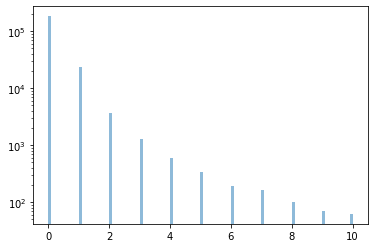

In [24]:
plt.hist(test.item_cnt_month, bins=100, range=[0, 10], alpha=0.5)
plt.yscale('log')
plt.show()